In [1]:
import random
import sys
from datetime import datetime, timedelta
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(str(Path().resolve().parent))
from paths import SCHEDULES, PREFERENCES, OUT

import ray

In [2]:
if ray.is_initialized:
    ray.shutdown()
ray.init(ignore_reinit_error=True)

2025-06-04 23:06:58,420	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.11.0
Ray version:,2.44.0
Dashboard:,http://127.0.0.1:8266


### Wczytanie i przygotowanie danych

In [3]:
plan = pd.read_csv(SCHEDULES / "schedule_1.csv", sep=None, engine="python")
pref = pd.read_csv(PREFERENCES / "prefs_1.csv")

In [4]:
plan["start_time"] = pd.to_datetime(plan["start_time"], format="%H:%M").dt.time

# Zmiana typu zajęć na ich pojemność
capacities = {
    "L": 15,
    "P": 15,
    "C": 30,
}

plan = plan[plan["type"] != "W"]
plan["type"] = plan["type"].map(capacities)
plan.rename(columns={"type": "capacity"}, inplace=True)
plan.head(5)

,subject,specialization,capacity,Unnamed: 3,group_id,teacher,classroom,week,day,start_time
0,Przedmiot-1,G,30,30,1,Prowadzący-15,3.27a,NaN,Cz,16:45:00
1,Przedmiot-1,G,30,30,2,Prowadzący-15,3.27b,NaN,Cz,16:45:00
2,Przedmiot-1,G,30,30,3,Prowadzący-15,3.27a,NaN,Cz,18:30:00
3,Przedmiot-1,G,30,30,4,Prowadzący-15,3.27c,NaN,Cz,16:45:00
4,Przedmiot-1,G,30,30,5,Prowadzący-15,3.27b,NaN,Cz,16:45:00


### Przydatne struktury i funkcje pomocniczne


In [5]:
from collections import defaultdict

# Przydatne struktury
students = pref["student_id"].unique()
subjects = plan["subject"].unique()

# Liczba grup dla każdego przedmiotu:
# subject -> number of groups
num_groups = {}
for subject in subjects:
    n = plan[plan["subject"] == subject]["group_id"].nunique()
    num_groups[subject] = n

# Preferencje studentów dla danych grup:
# (student_id, subject, group_id): preference
pref_dict = {
    (row.student_id, row.subject, row.group_id): row.preference
    for row in pref.itertuples()
}

# Pojemności grup:
# (subject, group_id): capacity
cap_dict = {(row.subject, row.group_id): row.capacity for row in plan.itertuples()}

# Posortowane preferencje (malejąco po przyznanych punktach):
# (student_id, subject): list of (group_id, preference)
pref_sorted = pref.sort_values(
    by=["student_id", "subject", "preference"], ascending=[True, True, False]
)
pref_dict_sorted = defaultdict(list)
for row in pref_sorted.itertuples():
    pref_dict_sorted[(row.student_id, row.subject)].append(
        (row.group_id, row.preference)
    )

# Przedziały czasowe zajęć poszczególnych grup
# (subject, group_id) -> (day, start_time, end_time)
schedule_dict = {}
DUR = timedelta(minutes=90)
for row in plan.itertuples():
    start = datetime.combine(datetime.today(), row.start_time)
    schedule_dict[(row.subject, row.group_id)] = (
        row.day,
        row.start_time,
        (start + DUR).time(),
    )

In [6]:
def conflicts(day_a, start_a, end_a, day_b, start_b, end_b):
    return (day_a == day_b) and (start_a < end_b) and (start_b < end_a)

In [7]:
def check_conflicts(individual):
    """
    Sprawdza, czy w danym planie są kolizje zajęć.
    """
    reserved = {stu: [] for stu in students}
    for student in individual.index:
        for subject in individual.columns:
            group_id = individual.loc[student, subject]
            day, s, e = schedule_dict[(subject, group_id)]
            if any(
                conflicts(day, s, e, d0, s0, e0) for d0, s0, e0 in reserved[student]
            ):
                return True

            reserved[student].append((day, s, e))
    return False

In [8]:
def check_overflow(individual: pd.DataFrame):
    occupancy = (
        individual
        .melt(var_name="subject", value_name="group_id")
        .dropna(subset=["group_id"])
        .groupby(["subject", "group_id"])
        .size()                                     
    )

    for (subj, group_id), count in occupancy.items():
        if cap_dict[(subj, group_id)] < count:
            return True
        
    return False

### Tworzenie populacji

In [9]:
from collections import Counter
@ray.remote
def generate_individual(
    plan, schedule_dict, num_groups, students, subjects, cap_dict, pref_dict_sorted
):
    """
    Generuje jednego osobnika (kompletne przypisanie studentów do grup)

    Dla każdego studenta, przypisuje go do najbardziej preferowanej grupy, w której
    jest jeszcze miejsce, i która nie koliduje z jego obecnym planem.
    Jeśli nigdzie nie ma miejsca, przypisuje go do grupy z najmniejszym przepełnieniem.
    """

    occupancy = {key: 0 for key in cap_dict}
    reserved = {stu: Counter() for stu in students}

    groups_by_subject = {
        subject: plan[plan["subject"] == subject]["group_id"].unique().tolist()
        for subject in subjects
    }

    df = pd.DataFrame(index=students, columns=subjects)
    for student in students:
        for subject in subjects:
            groups_ok = []
            overflowed_but_ok = []
            conflicts_but_ok = []

            for group_id in groups_by_subject[subject]:
                occupancy_flag = False
                conflict_flag = False

                if occupancy[(subject, group_id)] >= cap_dict.get(
                    (subject, group_id), 0
                ):
                    occupancy_flag = True

                day, s, e = schedule_dict[(subject, group_id)]
                if reserved[student][(day, s, e)] != 0:
                    conflict_flag = True

                if not occupancy_flag and not conflict_flag:
                    groups_ok.append(group_id)
                elif occupancy_flag and not conflict_flag:
                    overflowed_but_ok.append(group_id)
                elif not occupancy_flag and conflict_flag:
                    conflicts_but_ok.append(group_id)
                    
            if groups_ok:
                group_id = random.choice(groups_ok)
            elif conflicts_but_ok:
                group_id = random.choice(conflicts_but_ok)
                for stu_b in students:
                    if student != stu_b:
                        if pd.isna(grp_b := df.loc[stu_b, subject]):
                            continue
                        if group_id == grp_b:
                            continue

                        day_a, s_a, e_a = schedule_dict[(subject, group_id)]
                        day_b, s_b, e_b = schedule_dict[(subject, grp_b)]

                        if reserved[stu_b][(day_a, s_a, e_a)] != 0:
                            continue
                        if reserved[student][(day_b, s_b, e_b)] != 0:
                            continue

                        df.loc[stu_b, subject] = group_id
                        reserved[stu_b][(day_b, s_b, e_b)] -= 1
                        reserved[stu_b][(day_a, s_a, e_a)] += 1
                        occupancy[(subject, group_id)] += 1

                        group_id = grp_b
                        occupancy[(subject, group_id)] -= 1
                        break
                else: 
                    print(
                    f"Konflikt: Brak grup dla studenta {student} i przedmiotu {subject}"
                    )
                    group_id = random.randint(1, num_groups[subject])

            else:
                print(
                    f"Konflikt: Brak grup dla studenta {student} i przedmiotu {subject}"
                )
                group_id = random.randint(1, num_groups[subject])

            df.loc[student, subject] = group_id
            occupancy[(subject, group_id)] += 1
            reserved[student][schedule_dict[(subject, group_id)]] += 1
    return df

In [10]:
def generate_population(size, students, subjects, num_groups):
    population = []
    shuffled = students.copy()

    plan_ref = ray.put(plan)
    cap_dict_ref = ray.put(cap_dict)
    pref_dict_sorted_ref = ray.put(pref_dict_sorted)
    subjects_ref = ray.put(subjects)
    schedule_dict_ref = ray.put(schedule_dict)
    num_groups_ref = ray.put(num_groups)

    for _ in range(size):
        random.shuffle(shuffled)
        population.append(
            generate_individual.remote(
                plan_ref,
                schedule_dict_ref,
                num_groups_ref,
                shuffled,
                subjects_ref,
                cap_dict_ref,
                pref_dict_sorted_ref,
            )
        )

    return ray.get(population)

### Algorytm genetyczny

In [11]:
@ray.remote
def mutate_swap(
    students, schedule_dict, individual, mutation_rate=0.1, max_attempts=50
):
    mutated = individual.copy()
    reserved = {stu: Counter() for stu in students}
    students_list = students.tolist()

    for stu in mutated.index:
        for subj in mutated.columns:
            group_id = mutated.loc[stu, subj]
            reserved[stu][schedule_dict[(subj, group_id)]] += 1

    for stu_a in mutated.index:
        for subj in mutated.columns:
            if random.random() < mutation_rate:
                for _ in range(max_attempts):
                    stu_b = random.choice(students_list)

                    if stu_a == stu_b:
                        continue

                    if pd.isna(grp_a := mutated.loc[stu_a, subj]):
                        continue
                    if pd.isna(grp_b := mutated.loc[stu_b, subj]):
                        continue
                    if grp_a == grp_b:
                        continue

                    day_a, s_a, e_a = schedule_dict[(subj, grp_a)]
                    day_b, s_b, e_b = schedule_dict[(subj, grp_b)]

                    if reserved[stu_b][(day_a, s_a, e_a)] != 0:
                        continue
                    if reserved[stu_a][(day_b, s_b, e_b)] != 0:
                        continue

                    mutated.loc[stu_a, subj] = grp_b
                    mutated.loc[stu_b, subj] = grp_a

                    reserved[stu_a][(day_a, s_a, e_a)] -= 1
                    reserved[stu_a][(day_b, s_b, e_b)] += 1
                    reserved[stu_b][(day_b, s_b, e_b)] -= 1
                    reserved[stu_b][(day_a, s_a, e_a)] += 1

                    break
    return mutated

In [12]:
@ray.remote
def crossover_split(parent1, parent2, cut):
    """
    Krzyżuje dwóch osobników i zwraca nowego.

    Obecnie, bierze pół planu od jednego rodzica i pół do drugiego
    nie patrząc na żadne warunki Xd.
    """

    students = parent1.index.tolist()
    subjects = parent1.columns.tolist()

    child = pd.DataFrame(index=students, columns=subjects)

    for i, student in enumerate(students):
        source = parent1 if i < cut else parent2
        for subject in subjects:
            child.loc[student, subject] = source.loc[student, subject]

    return child

In [13]:
@ray.remote
def crossover(schedule_dict, parent1, parent2, cut):
    """
    Krzyżuje dwóch osobników i zwraca nowego.

    Birze z parenta2 wszystko co moze w wolne miejsca w parent1
    """

    child = parent1.copy()
    reserved = {stu: Counter() for stu in parent1.index}

    for student in child.index:
        for subject in child.columns:
            group_id = child.loc[student, subject]
            reserved[student][schedule_dict[(subject, group_id)]] += 1

    students = child.index.tolist()
    subjects = child.columns.tolist()

    for student in students:
        for subject in subjects:
            group_id = child.loc[student, subject]
            day, s, e = schedule_dict[(subject, group_id)]

            if reserved[student][(day, s, e)] == 0:
                # Szukamy grupy w parent2
                for group_id2 in parent2[subject].unique():
                    if group_id2 == group_id:
                        continue

                    day2, s2, e2 = schedule_dict[(subject, group_id2)]
                    if reserved[student][(day2, s2, e2)] == 0:
                        child.loc[student, subject] = group_id2
                        reserved[student][(day, s, e)] -= 1
                        reserved[student][(day2, s2, e2)] += 1
                        break

    return child

In [14]:
@ray.remote
def fitness(pref, individual, pref_dict):
    total_points = 0
    max_points = pref.groupby(["student_id", "subject"])["preference"].max().sum()

    for student in individual.index:
        for subject in individual.columns:
            group = individual.loc[student, subject]
            key = (student, subject, group)
            points = pref_dict.get(key, 0)

            total_points += points

    return float(round(total_points / max_points, 2))

In [15]:
def evolve(
    students,
    subjects,
    num_groups,
    pref_dict,
    population_size=100,
    generations=100,
    mutation_rate=0.1,
    elite_size=2,
    cut=0.5,
):
    population = generate_population(population_size, students, subjects, num_groups)
    best_individual = None
    best_fitness = -1e9
    history = []

    pref_ref = ray.put(pref)
    pref_dict_ref = ray.put(pref_dict)
    students_ref = ray.put(students)
    schedule_dict_ref = ray.put(schedule_dict)

    print("Starting evolution...")
    for gen in range(generations):
        scores = [
            fitness.remote(pref_ref, individual, pref_dict_ref)
            for individual in population
        ]
        scores = ray.get(scores)

        max_f = max(scores)
        history.append(max_f)

        if max_f > best_fitness:
            best_fitness = max_f
            best_individual = population[scores.index(max_f)]

        sorted_indices = sorted(
            range(len(scores)), key=lambda i: scores[i], reverse=True
        )

        elite_population = [population[i] for i in sorted_indices[:elite_size]]
        new_population = []

        while len(new_population) + len(elite_population) < population_size:
            p1 = random.choice(elite_population)
            p2 = random.choice(elite_population)
            child = crossover.remote(schedule_dict_ref, p1, p2, cut)
            child = mutate_swap.remote(
                students_ref, schedule_dict_ref, child, mutation_rate
            )

            new_population.append(child)

        population = ray.get(new_population)
        population.extend(elite_population)

        if gen % 10 == 0 or gen == generations - 1:
            print(f"Pokolenie {gen}: najlepszy fitness = {max_f}")

    return best_individual, best_fitness, history

### Ewolucja i generowanie wyników

In [16]:
population = generate_population(20, students, subjects, num_groups)
pref_ref = ray.put(pref)
pref_dict_ref = ray.put(pref_dict)

scores = ray.get(
    [fitness.remote(pref_ref, individual, pref_dict_ref) for individual in population]
)
print(list(scores))

[0.52, 0.54, 0.53, 0.52, 0.53, 0.53, 0.53, 0.54, 0.53, 0.53, 0.52, 0.55, 0.53, 0.53, 0.52, 0.55, 0.52, 0.52, 0.53, 0.53]


In [17]:
generate_population(1000, students, subjects, num_groups)

[            Przedmiot-1 Przedmiot-2 Przedmiot-3 Przedmiot-4 Przedmiot-6
 student_101           5           6           1           3           3
 student_106           2           3           1           4          16
 student_109           1           8           1           8           1
 student_47            6           4           1           8           4
 student_121           5           3           1           7           3
 ...                 ...         ...         ...         ...         ...
 student_10            8           4           7           2           2
 student_216           4           1           1           2           9
 student_40            4           4           1           6           1
 student_17            8           4           3           2           2
 student_19            8           4           8           2           2
 
 [240 rows x 5 columns],
             Przedmiot-1 Przedmiot-2 Przedmiot-3 Przedmiot-4 Przedmiot-6
 student_232           6

In [125]:
best, score, history = evolve(
    students=students,
    subjects=subjects,
    num_groups=num_groups,
    pref_dict=pref_dict,
    population_size=100,
    generations=50,
    mutation_rate=0.1,
    elite_size=40,
    cut=0.7,
)

print("Najlepszy fitness:", score)

Starting evolution...
Pokolenie 0: najlepszy fitness = 0.56
Pokolenie 10: najlepszy fitness = 0.58
Pokolenie 20: najlepszy fitness = 0.59
Pokolenie 30: najlepszy fitness = 0.59
Pokolenie 40: najlepszy fitness = 0.59
Pokolenie 49: najlepszy fitness = 0.6
Najlepszy fitness: 0.6


In [ ]:
best, score, history = evolve(
    students=students,
    subjects=subjects,
    num_groups=num_groups,
    pref_dict=pref_dict,
    population_size=100,
    generations=100,
    mutation_rate=0.4,
    elite_size=10,
    cut=0.7,
)

print("Najlepszy fitness:", score)

Starting evolution...
Pokolenie 0: najlepszy fitness = 0.45
Pokolenie 10: najlepszy fitness = 0.47
Pokolenie 20: najlepszy fitness = 0.47
Pokolenie 30: najlepszy fitness = 0.47
Pokolenie 40: najlepszy fitness = 0.47
Pokolenie 50: najlepszy fitness = 0.48
Pokolenie 60: najlepszy fitness = 0.48
Pokolenie 70: najlepszy fitness = 0.48
Pokolenie 80: najlepszy fitness = 0.48
Pokolenie 90: najlepszy fitness = 0.48
Pokolenie 99: najlepszy fitness = 0.48
Najlepszy fitness: 0.48


In [ ]:
best, score, history = evolve(
    students=students,
    subjects=subjects,
    num_groups=num_groups,
    pref_dict=pref_dict,
    population_size=100,
    generations=100,
    mutation_rate=0.8,
    elite_size=30,
)

print("Najlepszy fitness:", score)

Starting evolution...
Pokolenie 0: najlepszy fitness = 0.45
Pokolenie 10: najlepszy fitness = 0.46
Pokolenie 20: najlepszy fitness = 0.46
Pokolenie 30: najlepszy fitness = 0.46
Pokolenie 40: najlepszy fitness = 0.46
Pokolenie 50: najlepszy fitness = 0.46


KeyboardInterrupt: 

In [ ]:
best.to_csv(OUT / "output1.csv", sep=";")

In [ ]:
best.head(30)

,Przedmiot-1,Przedmiot-2,Przedmiot-3,Przedmiot-4,Przedmiot-6
student_1,4,2,2,2,10
student_2,2,4,2,8,16
student_3,3,1,5,4,17
student_4,6,3,2,2,15
student_5,7,5,2,8,1
student_6,8,1,2,6,2
student_7,3,1,4,3,9
student_8,1,3,2,8,7
student_9,6,3,3,7,2
student_10,7,6,7,6,3


### Testy i statystyki

In [ ]:
def score_per_student(df, pref_dict):
    scores = []
    max_points = pref.groupby(["student_id", "subject"])["preference"].max()

    for student in df.index:
        student_max = max_points[student].sum()
        student_score = 0
        for subject in df.columns:
            group = df.loc[student, subject]
            key = (student, subject, group)
            points = pref_dict.get(key, 0)

            student_score += points

        scores.append(round(student_score / student_max, 2))
    return scores

In [ ]:
scores = score_per_student(best, pref_dict)

[np.float64(0.98), np.float64(0.98), np.float64(0.91), np.float64(0.91), np.float64(0.91), np.float64(0.91), np.float64(0.91), np.float64(0.9), np.float64(0.9), np.float64(0.89), np.float64(0.89), np.float64(0.88), np.float64(0.88), np.float64(0.88), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.85), np.float64(0.85), np.float64(0.85), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.83), np.float64(0.83), np.float64(0.83), np.float64(0.83), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(

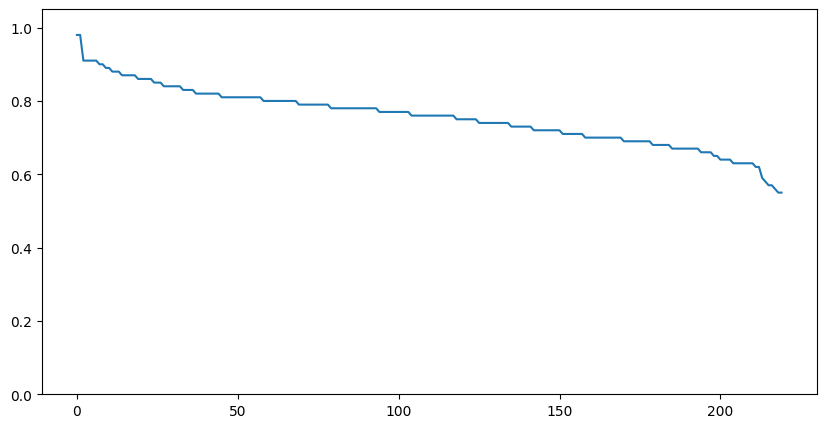

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylim(0, 1.05)
plt.plot(sorted(scores, reverse=True))
print(sorted(scores, reverse=True))